##  1. Imports and Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import sys
import tensorflow as tf
import warnings
import h5py
from pathlib import Path

from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output


##  Directory Setup

In [2]:
# Set directory paths ( Modify this to your own PC Path )
base_dir = r'C:\Users\kn010\OneDrive\Documents\Concordia files\ds-Machine-learning-project-4\ds-machine-learning-project-4-main\Bird-pictures'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

##  Data Loading and Verification

In [3]:
# Load dataset
df = pd.read_csv('../data/birds.csv')

# Verify species consistency across datasets
def verify_same_species_across_folders(df, folders):
    species_in_folders = {}
    for folder in folders:
        species_set = set(df[df['data set'] == folder]['scientific name'].unique())
        species_in_folders[folder] = species_set

    all_same = all(species_in_folders[folder] == species_in_folders[folders[0]] for folder in folders)
    if all_same:
        print("All folders contain the same classes of bird species.")
    else:
        print("Folders contain different classes of bird species.")
        for folder, species in species_in_folders.items():
            print(f"{folder} contains {len(species)} unique species.")

folders = ['train', 'test', 'valid']
verify_same_species_across_folders(df, folders)


All folders contain the same classes of bird species.


## Image Data Preparation

In [4]:
# Image data preprocessing and augmentation setup
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare generators
training_set = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_set = test_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')


Found 2422 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


In [5]:
#Python script that indexes all images within each folder in a specified directory, 
#  and pairs these image paths with their respective class names

def index_images_with_classes(directory):
    """
    Index all images in each subdirectory of the given directory and pair them with their respective class names.
    
    Arguments:
    directory -- the base directory containing class subdirectories.

    Returns:
    A list of tuples (class_name, image_path).
    """
    indexed_images = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Only process directories
            for image_filename in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_filename)
                if os.path.isfile(image_path):  # Make sure it's a file
                    indexed_images.append((class_name, image_path))
    return indexed_images

def main(base_dir):
    """
    Index images in train, valid, and test directories and print their paths paired with class names.
    """
    train_dir = os.path.join(base_dir, 'train')
    valid_dir = os.path.join(base_dir, 'valid')
    test_dir = os.path.join(base_dir, 'test')

    # Index images in each directory
    train_images = index_images_with_classes(train_dir)
    valid_images = index_images_with_classes(valid_dir)
    test_images = index_images_with_classes(test_dir)

    # Example printouts to verify output
    print("Training Images:")
    for class_name, image_path in train_images:
        print(f"Class: {class_name}, Image Path: {image_path}")
    
    print("\nValidation Images:")
    for class_name, image_path in valid_images:
        print(f"Class: {class_name}, Image Path: {image_path}")
    
    print("\nTesting Images:")
    for class_name, image_path in test_images:
        print(f"Class: {class_name}, Image Path: {image_path}")

if __name__ == "__main__":
    base_dir = r'C:\Users\kn010\OneDrive\Documents\Concordia files\ds-Machine-learning-project-4\ds-machine-learning-project-4-main\Bird-pictures'  # Update with the actual path to your dataset directory
    main(base_dir)

Training Images:
Class: ABBOTTS BABBLER, Image Path: C:\Users\kn010\OneDrive\Documents\Concordia files\ds-Machine-learning-project-4\ds-machine-learning-project-4-main\Bird-pictures\train\ABBOTTS BABBLER\001.jpg
Class: ABBOTTS BABBLER, Image Path: C:\Users\kn010\OneDrive\Documents\Concordia files\ds-Machine-learning-project-4\ds-machine-learning-project-4-main\Bird-pictures\train\ABBOTTS BABBLER\002.jpg
Class: ABBOTTS BABBLER, Image Path: C:\Users\kn010\OneDrive\Documents\Concordia files\ds-Machine-learning-project-4\ds-machine-learning-project-4-main\Bird-pictures\train\ABBOTTS BABBLER\003.jpg
Class: ABBOTTS BABBLER, Image Path: C:\Users\kn010\OneDrive\Documents\Concordia files\ds-Machine-learning-project-4\ds-machine-learning-project-4-main\Bird-pictures\train\ABBOTTS BABBLER\004.jpg
Class: ABBOTTS BABBLER, Image Path: C:\Users\kn010\OneDrive\Documents\Concordia files\ds-Machine-learning-project-4\ds-machine-learning-project-4-main\Bird-pictures\train\ABBOTTS BABBLER\005.jpg
Class: A

In [6]:
# Add small comments on what this does  *
def get_class_names_from_directory(directory):
    """Generate a list of class names based on the directory names in a given directory."""
    # List all items in the directory
    all_items = os.listdir(directory)
    # Filter out only directories (which are assumed to be class names)
    class_names = [item for item in all_items if os.path.isdir(os.path.join(directory, item))]
    class_names.sort()  # Optional: sort the list alphabetically
    return class_names

# Path to the validation directory
valid_dir = r'C:\Users\kn010\OneDrive\Documents\Concordia files\ds-Machine-learning-project-4\ds-machine-learning-project-4-main\Bird-pictures\valid'

# The class names
class_names = get_class_names_from_directory(valid_dir)
print(class_names)

['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET']


                                            Filepath            Label
0  C:\Users\kn010\OneDrive\Documents\Concordia fi...  ABBOTTS BABBLER
1  C:\Users\kn010\OneDrive\Documents\Concordia fi...  ABBOTTS BABBLER
2  C:\Users\kn010\OneDrive\Documents\Concordia fi...  ABBOTTS BABBLER
3  C:\Users\kn010\OneDrive\Documents\Concordia fi...  ABBOTTS BABBLER
4  C:\Users\kn010\OneDrive\Documents\Concordia fi...  ABBOTTS BABBLER


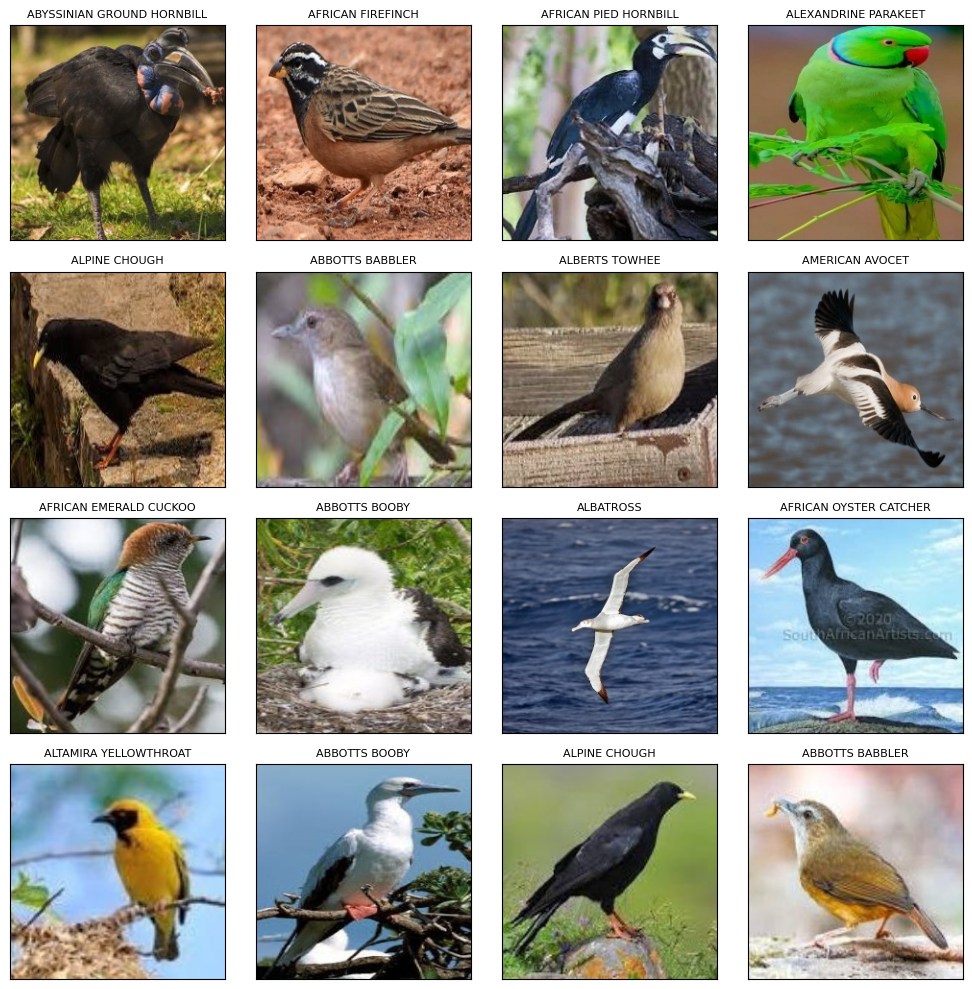

In [7]:
# Assuming you have a simple directory structure where each subfolder in 'train_dir' is named after its label
# and contains relevant images

def create_image_dataframe(directory):
    data = []
    for label in os.listdir(directory):
        path = os.path.join(directory, label)
        if os.path.isdir(path):
            for file in os.listdir(path):
                data.append({'Filepath': os.path.join(path, file), 'Label': label})
    return pd.DataFrame(data)

# Create DataFrame for training images
image_df = create_image_dataframe(train_dir)

# Verify the DataFrame creation
print(image_df.head())

# Now, proceed with the plotting code
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df['Filepath'].iloc[random_index[i]]))
    ax.set_title(image_df['Label'].iloc[random_index[i]], fontsize=8)
plt.tight_layout()
plt.show()

## Model Building and Compilation

In [8]:
# Define the model architecture using VGG16 as base

def create_model():
    base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = False  # Freeze the base to reuse pre-trained features
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(15, activation='softmax')(x)  # Adjust according to your class number
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = create_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,141,327 (80.65 MB)

 Trainable params: 6,426,639 (24.52 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [36]:
# This code trains a model, stopping early if it stops improving, saves the best version, and reduces the learning rate if progress stalls.

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3),
    ModelCheckpoint(filepath='path_to_save/Bird_model.keras', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

# Train the model
history = model.fit(training_set, epochs=10, callbacks=callbacks, validation_data=validation_set)

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9743 - loss: 0.0868 - val_accuracy: 0.8667 - val_loss: 0.3999 - learning_rate: 0.0010
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9885 - loss: 0.0462 - val_accuracy: 0.8533 - val_loss: 0.5184 - learning_rate: 0.0010
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9848 - loss: 0.0602 - val_accuracy: 0.9067 - val_loss: 0.3423 - learning_rate: 0.0010
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9978 - loss: 0.0215 - val_accuracy: 0.8667 - val_loss: 0.4042 - learning_rate: 0.0010
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9812 - loss: 0.0526 - val_accuracy: 0.9200 - val_loss: 0.3973 - learning_rate: 0.0010
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.9952 - loss: 0.0255 - val_accuracy: 0.8800 - val_loss: 0.4025 - learning_rate: 0.0010


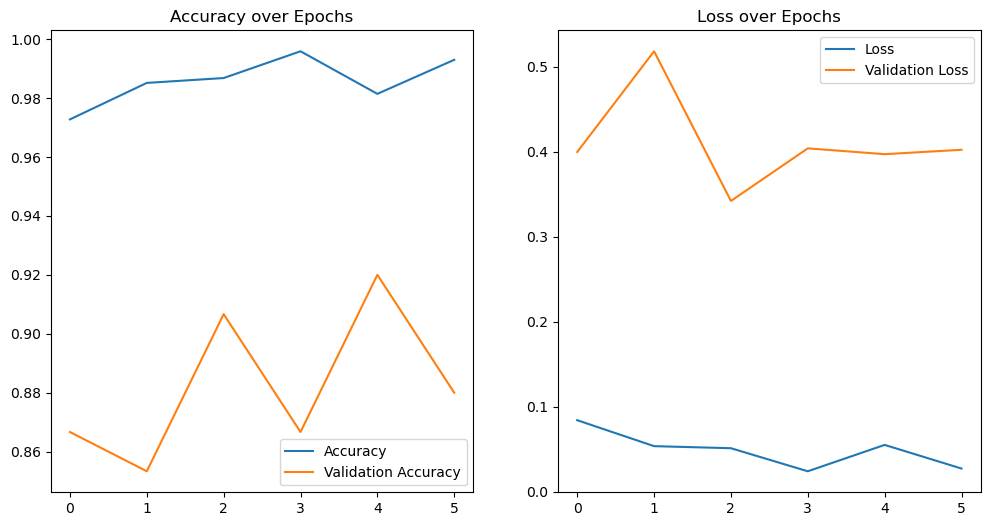

In [37]:
# This code creates a visual comparison of training and validation accuracy and loss across epochs in a two-panel plot.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

## Model Saving and Prediction

In [30]:
# Saving the model

model.save('New_model.h5')

In [31]:
#This code loads a previously saved model, prepares test data from a directory, 
#  evaluates the model on the test data to get loss and accuracy, and then prints the results.

model_saved = tf.keras.models.load_model('New_model.h5')

## Prepare test data
test_data_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

# Evaluate the model on test data
test_loss, test_accuracy = model_saved.evaluate(test_data_generator)

# Display results
print(f"Loss on test data: {test_loss}")
print(f"Accuracy on test data: {test_accuracy}")

Found 75 images belonging to 15 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9421 - loss: 0.1433
Loss on test data: 0.12447481602430344
Accuracy on test data: 0.9466666579246521


In [32]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,994,607 (129.68 MB)

 Trainable params: 6,426,639 (24.52 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 12,853,280 (49.03 MB)

In [33]:
# Add comments on this sections

def index_images_by_class(directory):
    """Index images by class, storing them in a dictionary."""
    images_by_class = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            images_by_class[class_name] = [
                os.path.join(class_dir, img) for img in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, img))
            ]
    return images_by_class

def load_model_and_predict(model_path, image_path, class_names):
    """Load the trained model and predict the class of the image."""
    model = load_model(model_path)
    img = load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    predicted_index = prediction.argmax(axis=-1)[0]
    predicted_class = class_names[predicted_index]
    return predicted_class


In [34]:
# Set the path to the directory containing the images and model
valid_dir = r'C:\Users\kn010\OneDrive\Documents\Concordia files\ds-Machine-learning-project-4\ds-machine-learning-project-4-main\Bird-pictures\valid'
model_path = 'New_model.h5'

# Index images by class
images_by_class = index_images_by_class(valid_dir)
class_names = list(images_by_class.keys())


In [35]:
# User specifies the class and image index
chosen_class = 'ALEXANDRINE PARAKEET'  # Modify class name as needed
image_index = 3  # Modify image index as needed


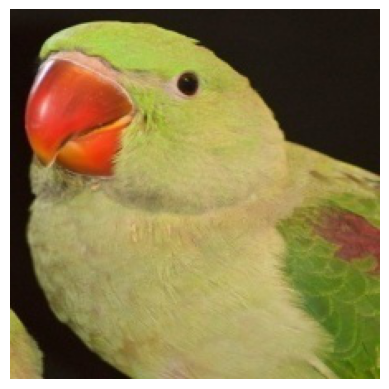

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Predicted class: ALEXANDRINE PARAKEET


In [27]:
# Cell for Performing Prediction

if chosen_class in images_by_class and len(images_by_class[chosen_class]) > image_index:
    image_path = images_by_class[chosen_class][image_index]
    predicted_class = load_model_and_predict(model_path, image_path, class_names)
    print(f"Predicted class: {predicted_class}")
else:
    print(f"No image found for class '{chosen_class}' at index {image_index}")
